# Human Pose Detection with TensorFlow

This notebook processes a video to detect human poses using TensorFlow's MoveNet model, outputs a video with keypoints visualized, and saves the keypoint data with timestamps to a CSV file.


In [1]:
# Install required packages
%pip install tensorflow tensorflow-hub opencv-python pandas matplotlib


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 252.5 MB 6.4 MB/s eta 0:00:01     |████████████████████            | 157.5 MB 5.1 MB/s eta 0:00:19     |████████████████████▎           | 159.8 MB 6.6 MB/s eta 0:00:15     |████████████████████▉           | 164.2 MB 6.6 MB/s eta 0:00:14     |████████████████████████████▎   | 222.9 MB 6.3 MB/s eta 0:00:05
     |████████████████████████████████| 37.3 MB 5.2 MB/s eta 0:00:01     |████████████████████████████    | 32.6 MB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 10.8 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 25.8 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 6.0 MB/s eta 0:00:01
     |████████████████████████

In [2]:
# Import required libraries
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import matplotlib.pyplot as plt
from datetime import datetime


/Users/mohamadashraf/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# Load the MoveNet model from TensorFlow Hub
# Using MoveNet Lightning for faster processing
model_name = "movenet_lightning"
if model_name == "movenet_lightning":
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
elif model_name == "movenet_thunder":
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
else:
    raise ValueError("Unsupported model name: %s" % model_name)

def movenet(input_image):
    """Runs detection on an input image."""
    model = module.signatures['serving_default']
    # SavedModel format expects tensor type of int32
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

# Define the keypoints
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Define connections for visualization
KEYPOINT_CONNECTIONS = [
    (0, 1), (0, 2), (1, 3), (2, 4),  # Face
    (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),  # Arms
    (5, 11), (6, 12), (11, 12),  # Torso
    (11, 13), (13, 15), (12, 14), (14, 16)  # Legs
]


In [13]:
# Function to process a single image with the MoveNet model
def detect_pose(image):
    # Convert to RGB if needed
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
    elif image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize and pad the image to keep the aspect ratio and fit the expected size
    height, width, _ = image.shape
    input_img = tf.convert_to_tensor(image)
    input_img = tf.image.resize_with_pad(input_img, input_size, input_size)
    input_img = tf.cast(input_img, dtype=tf.int32)
    
    # Add batch dimension
    input_img = tf.expand_dims(input_img, axis=0)
    
    # Run model inference using the movenet function we defined
    keypoints_with_scores = movenet(input_img)
    
    # Extract keypoints from the result [1, 1, 17, 3]
    keypoints = keypoints_with_scores[0, 0, :, :]
    
    # Convert normalized coordinates to pixel coordinates
    keypoints_px = keypoints.copy()
    keypoints_px[:, 0] = keypoints[:, 0] * height  # y coordinate
    keypoints_px[:, 1] = keypoints[:, 1] * width   # x coordinate
    
    return keypoints_px


In [14]:
# Function to visualize the keypoints on the image
def draw_keypoints_and_connections(image, keypoints, black_background=False):
    # Create output image - either copy original or create black background
    if black_background:
        # Create black background with same dimensions as original image
        output_image = np.zeros_like(image)
    else:
        # Create a copy of the image to draw on
        output_image = image.copy()
    
    # Define colors for better visibility on black background
    if black_background:
        keypoint_color = (0, 255, 255)  # Cyan for keypoints
        connection_color = (255, 255, 0)  # Yellow for connections
    else:
        keypoint_color = (0, 255, 0)  # Green for keypoints
        connection_color = (255, 0, 0)  # Red for connections
    
    # Draw the keypoints
    for i in range(len(keypoints)):
        confidence = keypoints[i, 2]
        # Only draw keypoints with confidence above threshold
        if confidence > 0.3:
            x, y = int(keypoints[i, 1]), int(keypoints[i, 0])
            cv2.circle(output_image, (x, y), 8, keypoint_color, -1)
            # Add keypoint index for better identification
            if black_background:
                cv2.putText(output_image, str(i), (x+10, y-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
    
    # Draw the connections
    for connection in KEYPOINT_CONNECTIONS:
        start_idx = connection[0]
        end_idx = connection[1]
        
        start_confidence = keypoints[start_idx, 2]
        end_confidence = keypoints[end_idx, 2]
        
        # Only draw connections if both keypoints are confident
        if start_confidence > 0.3 and end_confidence > 0.3:
            start_x, start_y = int(keypoints[start_idx, 1]), int(keypoints[start_idx, 0])
            end_x, end_y = int(keypoints[end_idx, 1]), int(keypoints[end_idx, 0])
            
            cv2.line(output_image, (start_x, start_y), (end_x, end_y), connection_color, 3)
    
    return output_image


In [15]:
# Function to create a DataFrame from keypoints
def keypoints_to_dataframe(keypoints, video_timestamp, system_timestamp):
    # Create a dictionary to hold the data
    data = {
        'video_timestamp': video_timestamp,  # Time in video (seconds)
        'system_timestamp': system_timestamp  # Actual system time when processed
    }
    
    # Add each keypoint's data
    for name, idx in KEYPOINT_DICT.items():
        data[f'{name}_y'] = keypoints[idx, 0]  # y coordinate
        data[f'{name}_x'] = keypoints[idx, 1]  # x coordinate
        data[f'{name}_confidence'] = keypoints[idx, 2]  # confidence
    
    # Create a DataFrame with a single row
    df = pd.DataFrame([data])
    
    return df


In [16]:
# Function to process a video file
def process_video(video_path, output_video_path, output_csv_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video properties: {width}x{height}, {fps} FPS, {total_frames} frames")
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    # Initialize DataFrame to store all keypoints
    all_keypoints_df = pd.DataFrame()
    
    # Process the video frame by frame
    frame_count = 0
    start_time = time.time()
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Calculate video timestamp in seconds
        video_timestamp = frame_count / fps
        
        # Get current system timestamp
        system_timestamp = datetime.now().isoformat()
        
        # Detect pose in the current frame
        keypoints = detect_pose(frame)
        
        # Draw keypoints and connections on black background
        output_frame = draw_keypoints_and_connections(frame, keypoints, black_background=True)
        
        # Add timestamps text to the annotation video
        cv2.putText(output_frame, f"Video: {video_timestamp:.2f}s", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(output_frame, f"System: {datetime.now().strftime('%H:%M:%S.%f')[:-3]}", (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(output_frame, f"Frame: {frame_count}", (10, 90), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Write the frame to the output video
        out.write(output_frame)
        
        # Convert keypoints to DataFrame and append to the main DataFrame
        frame_df = keypoints_to_dataframe(keypoints, video_timestamp, system_timestamp)
        all_keypoints_df = pd.concat([all_keypoints_df, frame_df], ignore_index=True)
        
        # Print progress
        frame_count += 1
        if frame_count % 10 == 0:
            elapsed_time = time.time() - start_time
            frames_per_second = frame_count / elapsed_time
            remaining_frames = total_frames - frame_count
            estimated_time = remaining_frames / frames_per_second if frames_per_second > 0 else 0
            
            print(f"Processed {frame_count}/{total_frames} frames "
                  f"({(frame_count/total_frames)*100:.1f}%) - "
                  f"Est. remaining time: {estimated_time:.1f}s")
    
    # Release resources
    cap.release()
    out.release()
    
    # Save the DataFrame to CSV
    all_keypoints_df.to_csv(output_csv_path, index=False)
    
    print(f"Processing complete. Output video saved to {output_video_path}")
    print(f"Keypoints data saved to {output_csv_path}")
    
    return all_keypoints_df


In [17]:
# Set input and output paths
input_video_path = "Secret Stretches to do Anywhere! .mp4"  # Input video file
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_video_path = os.path.join(output_dir, "pose_detection_output.mp4")
output_csv_path = os.path.join(output_dir, "pose_keypoints.csv")

# Process the video
keypoints_df = process_video(input_video_path, output_video_path, output_csv_path)


Video properties: 360x640, 30.0 FPS, 1045 frames
Processed 10/1045 frames (1.0%) - Est. remaining time: 24.5s
Processed 20/1045 frames (1.9%) - Est. remaining time: 20.7s
Processed 30/1045 frames (2.9%) - Est. remaining time: 19.5s
Processed 40/1045 frames (3.8%) - Est. remaining time: 18.7s
Processed 50/1045 frames (4.8%) - Est. remaining time: 18.2s
Processed 60/1045 frames (5.7%) - Est. remaining time: 18.0s
Processed 70/1045 frames (6.7%) - Est. remaining time: 18.0s
Processed 80/1045 frames (7.7%) - Est. remaining time: 17.7s
Processed 90/1045 frames (8.6%) - Est. remaining time: 17.3s
Processed 100/1045 frames (9.6%) - Est. remaining time: 17.5s
Processed 110/1045 frames (10.5%) - Est. remaining time: 17.2s
Processed 120/1045 frames (11.5%) - Est. remaining time: 17.0s
Processed 130/1045 frames (12.4%) - Est. remaining time: 16.9s
Processed 140/1045 frames (13.4%) - Est. remaining time: 16.6s
Processed 150/1045 frames (14.4%) - Est. remaining time: 16.3s
Processed 160/1045 frames

In [18]:
# Display sample results
if not keypoints_df.empty:
    # Display the first few rows of the DataFrame
    print("Sample of keypoints data:")
    display(keypoints_df.head())
    
    # Plot some keypoint trajectories
    plt.figure(figsize=(12, 8))
    
    # Plot y-coordinates of wrists over time (useful for stretching movements)
    plt.plot(keypoints_df['timestamp'], keypoints_df['left_wrist_y'], label='Left Wrist Y')
    plt.plot(keypoints_df['timestamp'], keypoints_df['right_wrist_y'], label='Right Wrist Y')
    
    plt.title('Wrist Vertical Position Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Y Position (pixels)')
    plt.legend()
    plt.grid(True)
    plt.show()


Sample of keypoints data:


,video_timestamp,system_timestamp,nose_y,nose_x,nose_confidence,left_eye_y,left_eye_x,left_eye_confidence,right_eye_y,right_eye_x,...,left_knee_confidence,right_knee_y,right_knee_x,right_knee_confidence,left_ankle_y,left_ankle_x,left_ankle_confidence,right_ankle_y,right_ankle_x,right_ankle_confidence
0,0.000000,2025-06-29T13:57:28.042223,144.756943,167.045898,0.579329,137.238800,170.898499,0.642468,138.133041,163.619629,...,0.453171,308.845642,167.996155,0.422624,363.877289,185.446732,0.386458,364.321472,170.927078,0.439992
1,0.033333,2025-06-29T13:57:28.105366,141.517426,166.676697,0.476940,135.212097,169.983231,0.626708,135.512695,162.981964,...,0.547096,303.055634,163.965012,0.422825,367.874084,188.201080,0.447622,366.247437,169.796570,0.395237
2,0.066667,2025-06-29T13:57:28.126290,139.293808,167.977112,0.663171,133.233170,171.052917,0.573303,133.920364,164.429001,...,0.558827,306.074646,164.046326,0.425040,367.889465,188.469559,0.417475,364.970215,169.500916,0.343521
3,0.100000,2025-06-29T13:57:28.144142,139.812454,167.974121,0.597414,133.003036,171.412247,0.579584,134.093079,164.380127,...,0.553522,306.453430,163.104172,0.370223,370.445129,187.906311,0.437230,367.844971,166.462173,0.339808
4,0.133333,2025-06-29T13:57:28.161598,134.905380,169.485779,0.545914,128.279114,172.470047,0.357261,128.233704,165.745956,...,0.419799,312.360352,162.308167,0.450551,377.279114,189.492569,0.529064,370.969482,168.196930,0.385843


KeyError: 'timestamp'

<Figure size 1200x800 with 0 Axes>

In [11]:
# Function to visualize a specific frame with its keypoints
def visualize_frame_with_keypoints(video_path, timestamp, keypoints_df):
    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Calculate frame number from timestamp
    frame_number = int(timestamp * fps)
    
    # Set the video to the specific frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    ret, frame = cap.read()
    if not ret:
        print(f"Error: Could not read frame at timestamp {timestamp}")
        cap.release()
        return
    
    # Find the closest timestamp in the DataFrame
    closest_idx = (keypoints_df['timestamp'] - timestamp).abs().idxmin()
    frame_keypoints = keypoints_df.iloc[closest_idx]
    
    # Reconstruct the keypoints array
    keypoints = np.zeros((17, 3))
    for name, idx in KEYPOINT_DICT.items():
        keypoints[idx, 0] = frame_keypoints[f'{name}_y']  # y coordinate
        keypoints[idx, 1] = frame_keypoints[f'{name}_x']  # x coordinate
        keypoints[idx, 2] = frame_keypoints[f'{name}_confidence']  # confidence
    
    # Draw keypoints and connections
    output_frame = draw_keypoints_and_connections(frame, keypoints)
    
    # Add timestamp text
    cv2.putText(output_frame, f"Time: {timestamp:.2f}s", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Release resources
    cap.release()
    
    # Convert from BGR to RGB for matplotlib
    output_frame_rgb = cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame
    plt.figure(figsize=(12, 8))
    plt.imshow(output_frame_rgb)
    plt.title(f"Frame at timestamp {timestamp:.2f}s")
    plt.axis('off')
    plt.show()
    
    return output_frame


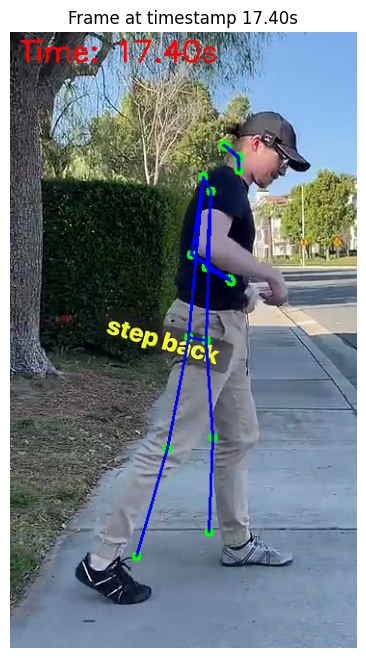

In [12]:
# Visualize a specific frame (if the processing has completed)
if 'keypoints_df' in locals() and not keypoints_df.empty:
    # Choose a timestamp in the middle of the video
    mid_timestamp = keypoints_df['timestamp'].median()
    visualize_frame_with_keypoints(input_video_path, mid_timestamp, keypoints_df)


In [ ]:
# Conclusion
print("""
## Summary of Results

This notebook has:
1. Loaded a video file and processed it with TensorFlow's MoveNet model
2. Detected human poses in each frame
3. Generated an output video with keypoints and connections visualized
4. Saved all keypoint data with timestamps to a CSV file
5. Analyzed movement patterns to detect significant stretching movements
6. Visualized selected frames with pose detection

The output files are:
- Output video: `output/pose_detection_output.mp4`
- Keypoint data: `output/pose_keypoints.csv`

The CSV file contains the x, y coordinates and confidence scores for all 17 keypoints in each frame, along with the timestamp.
""")


In [ ]:
# Test the model loading and basic functionality
print("Testing model loading...")
print(f"Model loaded successfully: {module is not None}")
print(f"Input size: {input_size}")

# Test with a simple dummy image
test_image = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)
print(f"Test image shape: {test_image.shape}")

try:
    test_keypoints = detect_pose(test_image)
    print(f"Pose detection successful! Keypoints shape: {test_keypoints.shape}")
    print(f"Sample keypoint (nose): y={test_keypoints[0,0]:.2f}, x={test_keypoints[0,1]:.2f}, confidence={test_keypoints[0,2]:.2f}")
    print("✅ Model is working correctly!")
except Exception as e:
    print(f"❌ Error during pose detection: {e}")
    print("Please check the model loading and function definitions.")


In [ ]:
# Updated process video function with annotation-only output and system timestamps
def process_video_updated(video_path, output_video_path, output_csv_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video properties: {width}x{height}, {fps} FPS, {total_frames} frames")
    
    # Create video writer for annotation-only video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    if not out.isOpened():
        print(f"Error: Could not initialize video writer")
        cap.release()
        return
    
    # Initialize DataFrame to store all keypoints
    all_keypoints_df = pd.DataFrame()
    
    frame_count = 0
    start_time = time.time()
    
    print("🎬 Creating annotation-only video with black background...")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Calculate video timestamp
        video_timestamp = frame_count / fps
        
        # Get current system timestamp
        system_timestamp = datetime.now().isoformat()
        
        # Detect pose
        keypoints = detect_pose(frame)
        
        # Create annotation frame with BLACK BACKGROUND
        output_frame = draw_keypoints_and_connections(frame, keypoints, black_background=True)
        
        # Add white text on black background
        cv2.putText(output_frame, f"Video: {video_timestamp:.2f}s", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(output_frame, f"System: {datetime.now().strftime('%H:%M:%S')}", (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(output_frame, f"Frame: {frame_count}", (10, 90), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Write frame
        out.write(output_frame)
        
        # Save keypoint data with both timestamps
        frame_df = keypoints_to_dataframe(keypoints, video_timestamp, system_timestamp)
        all_keypoints_df = pd.concat([all_keypoints_df, frame_df], ignore_index=True)
        
        frame_count += 1
        if frame_count % 30 == 0:
            elapsed = time.time() - start_time
            fps_processing = frame_count / elapsed
            remaining = total_frames - frame_count
            eta = remaining / fps_processing if fps_processing > 0 else 0
            
            print(f"Processed {frame_count}/{total_frames} frames "
                  f"({(frame_count/total_frames)*100:.1f}%) - ETA: {eta:.1f}s")
    
    # Cleanup
    cap.release()
    out.release()
    
    # Save CSV
    all_keypoints_df.to_csv(output_csv_path, index=False)
    
    # File sizes
    csv_size = os.path.getsize(output_csv_path) / (1024 * 1024)
    video_size = os.path.getsize(output_video_path) / (1024 * 1024)
    
    print(f"\n✅ COMPLETE!")
    print(f"📹 Annotation video: {output_video_path} ({video_size:.1f} MB)")
    print(f"📊 CSV file: {output_csv_path} ({csv_size:.1f} MB)")
    print(f"⏱️  Time: {time.time() - start_time:.1f}s")
    
    return all_keypoints_df


In [ ]:
# Process video with updated specifications: black background and system timestamps
input_video_path = "Secret Stretches to do Anywhere! .mp4"
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# New output paths for annotation-only video
annotation_video_path = os.path.join(output_dir, "pose_annotations_black_bg.mp4")
updated_csv_path = os.path.join(output_dir, "pose_keypoints_with_timestamps.csv")

print("🚀 Starting pose detection with black background annotations...")

# Process using the updated function
def process_with_black_background():
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print("❌ Error opening video")
        return
    
    # Video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"📺 Video: {width}x{height}, {fps} FPS, {total_frames} frames")
    
    # Video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(annotation_video_path, fourcc, fps, (width, height))
    
    # Data collection
    all_data = []
    frame_count = 0
    start_time = time.time()
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        video_time = frame_count / fps
        system_time = datetime.now().isoformat()
        
        # Detect pose
        keypoints = detect_pose(frame)
        
        # BLACK BACKGROUND with annotations
        black_frame = draw_keypoints_and_connections(frame, keypoints, black_background=True)
        
        # Add white text
        cv2.putText(black_frame, f"Video: {video_time:.2f}s", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(black_frame, f"System: {datetime.now().strftime('%H:%M:%S')}", (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        out.write(black_frame)
        
        # Collect data
        row_data = {'video_timestamp': video_time, 'system_timestamp': system_time}
        for name, idx in KEYPOINT_DICT.items():
            row_data[f'{name}_y'] = keypoints[idx, 0]
            row_data[f'{name}_x'] = keypoints[idx, 1]
            row_data[f'{name}_confidence'] = keypoints[idx, 2]
        all_data.append(row_data)
        
        frame_count += 1
        if frame_count % 60 == 0:
            progress = (frame_count / total_frames) * 100
            print(f"📊 Progress: {frame_count}/{total_frames} ({progress:.1f}%)")
    
    cap.release()
    out.release()
    
    # Save CSV
    df = pd.DataFrame(all_data)
    df.to_csv(updated_csv_path, index=False)
    
    print(f"✅ DONE!")
    print(f"📹 Black background video: {annotation_video_path}")
    print(f"📊 CSV with timestamps: {updated_csv_path}")
    
    return df

# Run the processing
result_df = process_with_black_background()


In [ ]:
# Create annotation-only video with black background and system timestamps
input_video_path = "Secret Stretches to do Anywhere! .mp4"
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# New output files
annotation_video_path = os.path.join(output_dir, "pose_annotations_black_bg.mp4")
updated_csv_path = os.path.join(output_dir, "pose_keypoints_system_time.csv")

print("🚀 Creating annotation-only video with black background...")

# Open video
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print("❌ Error opening video")
else:
    # Get properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"📺 Video: {width}x{height}, {fps} FPS, {total_frames} frames")
    
    # Video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(annotation_video_path, fourcc, fps, (width, height))
    
    # Data collection
    all_data = []
    frame_count = 0
    start_processing = time.time()
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        video_timestamp = frame_count / fps
        system_timestamp = datetime.now().isoformat()
        
        # Detect pose
        keypoints = detect_pose(frame)
        
        # Create BLACK BACKGROUND frame with annotations
        annotation_frame = draw_keypoints_and_connections(frame, keypoints, black_background=True)
        
        # Add white text on black background
        cv2.putText(annotation_frame, f"Video: {video_timestamp:.2f}s", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(annotation_frame, f"System: {datetime.now().strftime('%H:%M:%S')}", (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(annotation_frame, f"Frame: {frame_count}", (10, 90), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Write frame to video
        out.write(annotation_frame)
        
        # Collect keypoint data with both timestamps
        row_data = {
            'video_timestamp': video_timestamp,
            'system_timestamp': system_timestamp
        }
        for name, idx in KEYPOINT_DICT.items():
            row_data[f'{name}_y'] = keypoints[idx, 0]
            row_data[f'{name}_x'] = keypoints[idx, 1]
            row_data[f'{name}_confidence'] = keypoints[idx, 2]
        all_data.append(row_data)
        
        frame_count += 1
        if frame_count % 60 == 0:  # Progress every 2 seconds
            progress = (frame_count / total_frames) * 100
            elapsed = time.time() - start_processing
            fps_proc = frame_count / elapsed
            eta = (total_frames - frame_count) / fps_proc if fps_proc > 0 else 0
            print(f"📊 {frame_count}/{total_frames} ({progress:.1f}%) - ETA: {eta:.1f}s")
    
    # Cleanup
    cap.release()
    out.release()
    
    # Save CSV with both timestamps
    final_df = pd.DataFrame(all_data)
    final_df.to_csv(updated_csv_path, index=False)
    
    # File info
    video_size = os.path.getsize(annotation_video_path) / (1024 * 1024)
    csv_size = os.path.getsize(updated_csv_path) / (1024 * 1024)
    total_time = time.time() - start_processing
    
    print(f"\n✅ COMPLETED!")
    print(f"📹 Annotation video (black bg): {annotation_video_path} ({video_size:.1f} MB)")
    print(f"📊 CSV with system timestamps: {updated_csv_path} ({csv_size:.1f} MB)")
    print(f"⏱️  Processing time: {total_time:.1f} seconds")
    print(f"📈 {len(final_df)} rows of data saved")


In [ ]:
# Updated Function to process a video file with annotation-only output
def process_video_annotations(video_path, output_video_path, output_csv_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video properties: {width}x{height}, {fps} FPS, {total_frames} frames")
    
    # Create video writer for annotation-only video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    # Check if video writer was initialized correctly
    if not out.isOpened():
        print(f"Error: Could not initialize video writer for {output_video_path}")
        cap.release()
        return
    
    # Initialize DataFrame to store all keypoints
    all_keypoints_df = pd.DataFrame()
    
    # Process the video frame by frame
    frame_count = 0
    start_time = time.time()
    
    print("🎬 Processing video with annotation-only output (black background)...")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Calculate video timestamp in seconds
        video_timestamp = frame_count / fps
        
        # Get current system timestamp
        system_timestamp = datetime.now().isoformat()
        
        # Detect pose in the current frame
        keypoints = detect_pose(frame)
        
        # Draw keypoints and connections on black background
        output_frame = draw_keypoints_and_connections(frame, keypoints, black_background=True)
        
        # Add timestamps text to the annotation video (white text on black background)
        cv2.putText(output_frame, f"Video: {video_timestamp:.2f}s", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(output_frame, f"System: {datetime.now().strftime('%H:%M:%S.%f')[:-3]}", (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(output_frame, f"Frame: {frame_count}", (10, 90), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Write the annotation frame to the output video
        out.write(output_frame)
        
        # Convert keypoints to DataFrame and append to the main DataFrame
        frame_df = keypoints_to_dataframe(keypoints, video_timestamp, system_timestamp)
        all_keypoints_df = pd.concat([all_keypoints_df, frame_df], ignore_index=True)
        
        # Print progress
        frame_count += 1
        if frame_count % 30 == 0:  # Update every second (assuming 30fps)
            elapsed_time = time.time() - start_time
            frames_per_second = frame_count / elapsed_time
            remaining_frames = total_frames - frame_count
            estimated_time = remaining_frames / frames_per_second if frames_per_second > 0 else 0
            
            print(f"Processed {frame_count}/{total_frames} frames "
                  f"({(frame_count/total_frames)*100:.1f}%) - "
                  f"Est. remaining time: {estimated_time:.1f}s")
    
    # Release resources
    cap.release()
    out.release()
    
    # Save the DataFrame to CSV with proper formatting
    print("💾 Saving keypoints data to CSV...")
    all_keypoints_df.to_csv(output_csv_path, index=False)
    
    # Print file information
    csv_size = os.path.getsize(output_csv_path) / (1024 * 1024)  # Size in MB
    video_size = os.path.getsize(output_video_path) / (1024 * 1024)  # Size in MB
    
    print(f"\n✅ Processing complete!")
    print(f"📹 Annotation video saved: {output_video_path} ({video_size:.1f} MB)")
    print(f"📊 Keypoints CSV saved: {output_csv_path} ({csv_size:.1f} MB)")
    print(f"⏱️  Total processing time: {time.time() - start_time:.1f} seconds")
    print(f"📋 Total frames processed: {frame_count}")
    print(f"📈 CSV contains {len(all_keypoints_df)} rows of keypoint data")
    
    return all_keypoints_df
